# Finding guide star candidates for PFS

Task: for a given planned observation, query online star catalogs for suitable stars falling into the AG cam FOVs

## Inputs:

### User supplied (change with every call)
   - RA, Dec
   - PA (position angle)
   - point in time

### Instrument characteristics (typically fixed)
   - magnitude limits for guide stars and their potential close neighbours
   - location of the AG cam FOVs in the focal plane
     (6 quadrilaterals, can be expressed as an array of shape (6,4,2)
   - coordinate transformation between focal plane coordinates (mm) and sky (RA, Dec)
     (delivered as part of the `pfs_utils` package)

### Star catalog
We currently use ADQL queries against GAIA DR2, but other catalogs can be used with very little work
   

## Criteria for guide star selection:

- must lie (sufficiently far) inside the FOV
- must have proper motion data for accurate position determination
- must be above a given brightness threshold
- must _not_ be closer than a given distance to other stars above another brightness threshold.

## Deliverables:

- list of potential guide star IDs for every camera
- finder charts (not yet done)

In [1]:
#Preliminaries

import numpy as np

# coordinate transform functionality
# using a local copy of pfs_utils for the moment ... this will change
from coordinates.CoordTransp import CoordinateTransform as ctrans

# query-related helper functions
from ets_shuffle import query_utils

# (mis-)using matplotlib for "point-in-polygon" queries
# may be replaced by real polygon ADQL queries in the future
%matplotlib notebook
import matplotlib.path as mppath



>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]


In [2]:
def main():
    # Section with externally provided parameters
    # (We don't know how these will be delivered / can be obtained yet,
    # so we hardwire them for the moment

    obs_time = "2020-01-01 15:00:00"
    # telescope pointing
    raTel_deg, decTel_deg = 34., -3.
    # focal plane position angle
    pa_deg = 0.
    # maximum magnitude for guide stars
    guidestar_mag_max = 19
    # maximum magnitude for close neighours of guide stars
    guidestar_neighbor_mag_max = 21
    # minimum distance (in degrees) between guide star candidates
    guidestar_minsep_deg = 1./3600

    # guide star cam geometries
    # stored internally as a (6,4,2) float array with 2D PFI coordinates
    # of the 4 corners of the 6 guide star cams.
    agcoord = guidecam_geometry()

    # internal, technical parameters
    # generous estimate of the focal plane radius
    fp_rad_deg = 260. * 10.2/3600

    # Query GAIA2 for a circular region containing all guide cam FOVs
    # Obtain all targets with g_mean_mag<=guidestar_neighbor_mag_max that have
    # proper motion information
    conn, table, coldict = query_utils.openGAIA2connection()
    # shorthand for the column names that the GAIA catalog uses for toring target RA, Dec
    racol, deccol = coldict["ra"], coldict["dec"]
    # These are the columns we are going to need
    req_columns = [coldict["id"], racol, deccol, coldict["pmra"],
                   coldict["pmdec"], 'phot_g_mean_mag']

    constraints = [
        # targets need to lie in the focal plane
        query_utils.build_circle_query(
            raTel_deg, decTel_deg, fp_rad_deg*1.2, coldict),
        # targets need to have proper motion information
        query_utils.build_pm_query(coldict),
        # targets need to be at least as bright as guidestar_neighbor_mag_max
        query_utils.build_mag_query(guidestar_neighbor_mag_max, 0,
                                    'phot_g_mean_mag')]

    res = query_utils.run_query(conn, table, req_columns, constraints)
    print("Initial query found {} targets".format(res[racol].size))

    print("adjusting for proper motion")
    obs_year = float(obs_time[0:4])
    raold, decold = res[racol][0], res[deccol][0]
    res[racol], res[deccol] = \
        update_coords_for_proper_motion(res[racol], res[deccol],
                                        res[coldict["pmra"]],
                                        res[coldict["pmdec"]], 2000., obs_year)
    print("DEBUG: target 0 moved from ({},{}) to ({},{}) due to proper motion".format(raold, decold, res[racol][0], res[deccol][0]))
    
    # compute PFI coordinates
    print("converting RA/Dec to PFI coordinates")
    tmp = np.array([res[racol], res[deccol]])
    tmp = ctrans(xyin=tmp,
                 za=0., mode="sky_pfi", inr=0., pa=pa_deg,
                 cent=np.array([raTel_deg, decTel_deg]),
                 time=obs_time)
    res["xypos"] = np.array([tmp[0, :], tmp[1, :]]).T
    print("DEBUG: target 0 is at ({},{}) in the focal plane.".format(res["xypos"][0,0],res["xypos"][0,1]))
    
    candidates = select_candidates(res, agcoord, guidestar_mag_max, guidestar_minsep_deg, racol, deccol)
    print("\nIdentified target IDs for each camera:")
    for i, d in enumerate(candidates):
        print("AG camera #{}".format(i))
        print(d[coldict["id"]])
    plot_focal_plane(agcoord, candidates)
  

In [3]:
# returns a (6,4,2) float array with PFI coordinates of the 4 corners
# of the 6 guide star cams.
# This is a placeholder until we know how to obtain the real geometry
# rough values are taken from
# https://sumire.pbworks.com/w/file/58576912/agcamerastudy.pdf
def guidecam_geometry():
    # The AG camera is described by its 4 corners. Let's use a square with
    # 10 mm side length for now, at 25mm distance from the center
    agcoord0 = np.zeros((4, 2))
    dist = 250.
    sidelength = 15.
    agcoord0[0, :] = [-.5*sidelength, -.5*sidelength]
    agcoord0[1, :] = [+.5*sidelength, -.5*sidelength]
    agcoord0[2, :] = [+.5*sidelength, +.5*sidelength]
    agcoord0[3, :] = [-.5*sidelength, +.5*sidelength]
    agcoord0[:, 0] += dist
    # get the remaining cameras via 60-degree rotations
    agcoord = np.zeros((6, 4, 2))
    for i in range(0, 6):
        ang = (30. + 60.*i)*np.pi/180.
        ca, sa = np.cos(ang), np.sin(ang)
        for j in range(4):
            x, y = agcoord0[j, :]
            agcoord[i, j, :] = ca*x - sa*y, ca*y + sa*x
    return agcoord

In [4]:
def update_coords_for_proper_motion(ra, dec, pmra, pmdec, epoch_cat,
                                    epoch_now):
    deltaRA = (epoch_now - epoch_cat)*pmra/3600000./np.cos(dec*np.pi/180.)
    deltaDE = (epoch_now - epoch_cat)*pmdec/3600000.
    return ra+deltaRA, dec+deltaDE

In [5]:
def select_candidates(res, agcoord, guidestar_mag_max, guidestar_minsep_deg, racol, deccol):
    # determine the subset of sources falling within the guide cam FOVs
    # For the moment I'm using matplotlib's path functionality for this task
    # Once the "pfi_sky" transformation direction is available in
    # pfs_utils.coordinates, we can do a direct polygon query for every camera,
    # which should be more efficient.
    tgtcam = []
    for i in range(agcoord.shape[0]):
        p = mppath.Path(agcoord[i])
        # find all targets in the slighty enlarged FOV
        tmp = p.contains_points(res["xypos"], radius=1.)  # 1mm more
        tdict = {}
        for key, val in res.items():
            tdict[key] = val[tmp]
        # eliminate close neighbors
        flags = flag_close_pairs(tdict[racol], tdict[deccol],
                                 guidestar_minsep_deg)
        for key, val in tdict.items():
            tdict[key] = val[np.invert(flags)]
        # eliminate all targets which are not bright enough to be guide stars
        flags = tdict["phot_g_mean_mag"] < guidestar_mag_max
        for key, val in tdict.items():
            tdict[key] = val[flags]
        # eliminate all targets which are not really in the camera's FOV
        flags = p.contains_points(tdict["xypos"])  # 1mm more
        for key, val in tdict.items():
            tdict[key] = val[flags]
        # append the results for this camera to the full list
        tgtcam.append(tdict)
    return tgtcam

In [6]:
def flag_close_pairs(ra, dec, radius):
    ra, dec = ra*np.pi/180, dec*np.pi/180
    rsq = (radius*np.pi/180)**2
    assert ra.ndim == 1 and dec.ndim == 1 and ra.shape[0] == dec.shape[0],\
        "bad input"
    nval = ra.shape[0]
    xyz = np.zeros((nval, 3), dtype=np.float64)
    cdec = np.cos(dec)
    xyz[..., 0] = cdec*np.cos(ra)
    xyz[..., 1] = cdec*np.sin(ra)
    xyz[..., 2] = np.sin(dec)
    flags = np.zeros(nval, dtype=np.bool)
    for i in range(ra.shape[0]):
        distsq = ((xyz[i, 0]-xyz[i+1:, 0])**2
                  + (xyz[i, 1]-xyz[i+1:, 1])**2
                  + (xyz[i, 2]-xyz[i+1:, 2])**2)
        tflags = distsq < rsq
        if np.any(tflags):
            flags[i] = True
        flags[i+1:] = flags[i+1:] | tflags
    return flags


In [7]:
def plot_focal_plane(cameras, gstargets):
    import matplotlib.pyplot as plt
    import matplotlib.path as mppath
    import matplotlib.patches as patches
    fig, ax = plt.subplots()
    for i in range(cameras.shape[0]):
        p = mppath.Path(cameras[i, (0, 1, 2, 3, 0), :], closed=True)
        patch = patches.PathPatch(p, fill=False)
        ax.add_patch(patch)
        ax.scatter(gstargets[i]["xypos"][:,0], gstargets[i]["xypos"][:,1], color='r')
    ax.set_xlim(-300, 300)
    ax.set_ylim(-300, 300)
 #   ax.scatter(targets[:, 0], targets[:, 1], color='g', marker=".")
    plt.show()


Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
INFO: Query finished. [astroquery.utils.tap.core]
Initial query found 5400 targets
adjusting for proper motion
DEBUG: target 0 moved from (34.400900656287746,-3.7374329550508416) to (34.400742349273685,-3.73755383684854) due to proper motion
converting RA/Dec to PFI coordinates
DEBUG: target 0 is at (-101.41770827158429,258.25618885240425) in the focal plane.

Identified target IDs for each camera:
AG camera #0
[2493596405047282176 2493597813796555648]
AG camera #1
[2492943913615230592 2492943913615227776 2492991020816540672]
AG camera #2
[2492877221363219712]
AG camera #3
[2493142272384857344 2493142448479083136 2493142169305639680
 2493142585918005120]
AG camera #4
[2494051431062162944 2494051057400740608 2494047999384032512
 2494050988681269248 2494051362342685056 249405098438

<IPython.core.display.Javascript object>


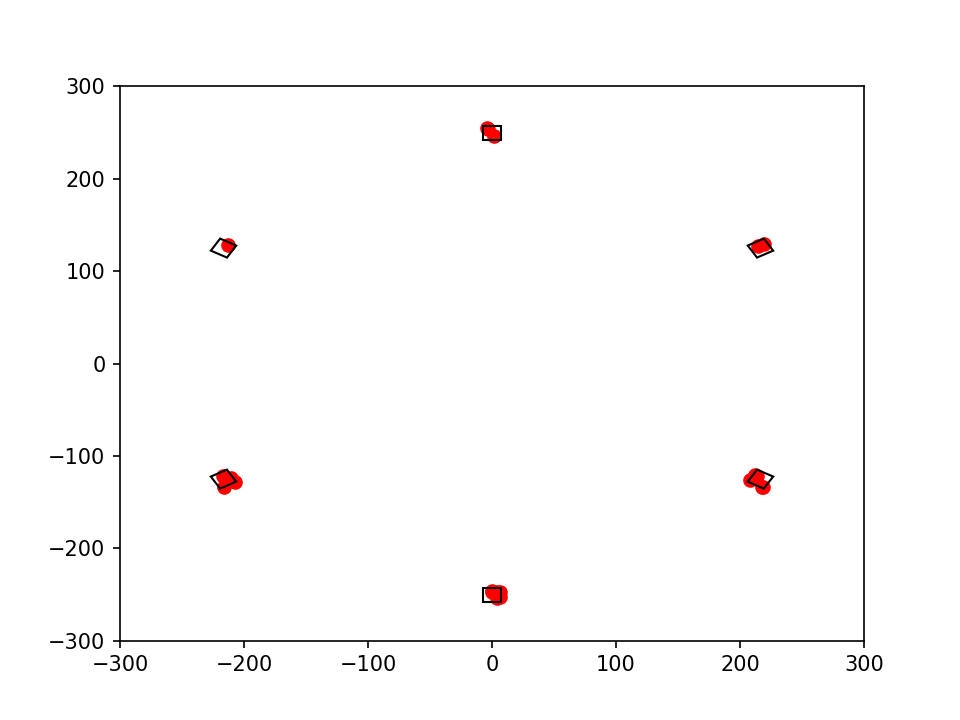

In [8]:
main()
